In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# load historical hourly data

In [2]:
node_RT = pd.read_csv("../data/Node_RT.csv")
node_DA = pd.read_csv("../data/Node_DA.csv")

In [3]:
node_RT_LMP = node_RT[node_RT['VALUE'] == 'LMP']
node_RT_LMP = node_RT_LMP.drop(columns=node_RT_LMP.columns[0])#.set_index('MARKET_DAY')

node_DA_LMP = node_DA[node_DA['VALUE'] == 'LMP']
node_DA_LMP = node_DA_LMP.drop(columns=node_DA_LMP.columns[0])#.set_index('MARKET_DAY')

# get stats from historical data
## for each month and hour, get mean and sigma

In [8]:
def monthly_stats(df):
    df = df.assign(
        DATE=pd.to_datetime(df['MARKET_DAY']),
        MONTH=lambda d: d['DATE'].dt.month
    )
    long = df.melt(
        ['DATE','MONTH'],
        [f'HE{i}' for i in range(1,25)],
        var_name='HOUR', value_name='PRICE'
    )
    long['PRICE'] = pd.to_numeric(long['PRICE'], errors='coerce')
    long = long.dropna(subset=['PRICE'])
    long['HOUR'] = long['HOUR'].str.extract(r'HE(\d+)').astype(int)

    stats = (
        long
        .groupby(['MONTH','HOUR'])['PRICE']
        .agg(mu='mean', sigma='std', n='count')
        .reset_index()
    )
    return stats


In [9]:
rt_stats = monthly_stats(node_RT_LMP)
da_stats = monthly_stats(node_DA_LMP)

In [10]:
rt_stats

,MONTH,HOUR,mu,sigma,n
0,1,1,35.734624,22.977619,93
1,1,2,34.731828,23.853920,93
2,1,3,31.057849,15.322579,93
3,1,4,31.478172,18.820488,93
4,1,5,30.612796,14.382946,93
...,...,...,...,...,...
283,12,20,43.097849,56.746852,93
284,12,21,45.601613,69.884598,93
285,12,22,36.064516,28.939219,93
286,12,23,37.430000,32.954692,93


In [13]:
da_stats

,MONTH,HOUR,mu,sigma,n
0,1,1,38.706022,26.095487,93
1,1,2,35.495484,23.306034,93
2,1,3,33.892151,23.101998,93
3,1,4,33.875914,22.997901,93
4,1,5,34.423226,23.920835,93
...,...,...,...,...,...
283,12,20,44.738710,23.169333,93
284,12,21,41.776344,21.191797,93
285,12,22,39.051828,18.540814,93
286,12,23,36.054624,18.201821,93


# build simulation structure

In [18]:
# build hourly index for Jul 1 2025 → Jun 30 2026
rng = pd.date_range('2025-07-01', '2026-06-30 23:00', freq='h')
sim_df = pd.DataFrame({'DT': rng})
sim_df['MONTH'] = sim_df.DT.dt.month
sim_df['HOUR']  = sim_df.DT.dt.hour + 1         # HE1–HE24

# attach monthly‐hourly DA stats
sim_df = sim_df.merge(da_stats, on=['MONTH','HOUR'], how='left')

# attach monthly‐hourly RT stats
sim_df = sim_df.merge(rt_stats, on=['MONTH','HOUR'], how='left', suffixes=('_DA','_RT'))

In [19]:
sim_df

,DT,MONTH,HOUR,mu_DA,sigma_DA,n_DA,mu_RT,sigma_RT,n_RT
0,2025-07-01 00:00:00,7,1,21.359839,3.215647,62,21.455000,10.613951,62
1,2025-07-01 01:00:00,7,2,18.899677,3.054796,62,18.186129,3.652654,62
2,2025-07-01 02:00:00,7,3,17.590645,3.213022,62,17.400000,4.118581,62
3,2025-07-01 03:00:00,7,4,16.919194,3.001962,62,16.307258,3.581187,62
4,2025-07-01 04:00:00,7,5,17.604194,2.847342,62,17.082097,3.222286,62
...,...,...,...,...,...,...,...,...,...
8755,2026-06-30 19:00:00,6,20,39.687333,15.916640,60,47.108667,58.212010,60
8756,2026-06-30 20:00:00,6,21,35.949500,12.214882,60,43.387500,44.837935,60
8757,2026-06-30 21:00:00,6,22,29.600000,8.870380,60,40.032667,79.575471,60
8758,2026-06-30 22:00:00,6,23,24.689000,6.082398,60,25.339500,15.791858,60


# simulations loop

In [21]:
# assumptions
n_miners    = 1000
power_mw    = n_miners * 3.25/1000          # 3.25 kW each → 3.25 MW total
btc_per_day = n_miners * 0.00008            # BTC/day total
btc_price0  = 93_000                        # starting BTC/USD
sigma_daily = 0.001                         # 0.1% per day
sigma_hour  = sigma_daily / np.sqrt(24)     # convert to hourly vol

In [ ]:
hours   = len(sim_df)
n_sims  = 500
profits = pd.DataFrame(columns=['DA', 'RT'])

hourly_paths_DA = []
hourly_paths_RT = []

for i in range(n_sims):
    # 1) simulate BTC/USD path over each hour (GBM w/ zero drift)
    eps        = np.random.normal(0, sigma_hour, size=hours)
    price_fac  = np.exp(eps)                      # multiplicative factors
    btc_path   = btc_price0 * price_fac.cumprod() # size: (hours,)

    # 2) sample DA and RT LMP each hour
    P_da       = np.random.normal(sim_df.mu_DA, sim_df.sigma_DA)
    P_rt       = np.random.normal(sim_df.mu_RT, sim_df.sigma_RT)


    # 3) compute revenue & cost per hour
    rev_hourly = btc_per_day * btc_path / 24      # $ revenue each hour
    cost_hourly_da = P_da * power_mw

    cost_hourly_rt = P_rt * power_mw

    # 4) annual profit for this sim
    profits.loc[i, 'DA'] = (rev_hourly - cost_hourly_da).sum()
    profits.loc[i, 'RT'] = (rev_hourly - cost_hourly_rt).sum()

    hourly_paths_DA.append(rev_hourly - cost_hourly_da)
    hourly_paths_RT.append(rev_hourly - cost_hourly_rt)


# summary
print("Mean profit (only buying in DA):  ", profits['DA'].mean())
print("Profit sigma (only buying in DA):  ", profits['DA'].std())

print("Mean profit (only buying in RT):  ", profits['RT'].mean())
print("Profit sigma (only buying in RT):  ", profits['RT'].std())

Mean profit (only buying in DA):   1790754.897755749
Profit sigma (only buying in DA):   30527.048893394596
Mean profit (only buying in RT):   1815042.3132956906
Profit sigma (only buying in RT):   32276.43407358275


# intraday analysis

In [27]:
hourly_profits_DA_df = pd.DataFrame(hourly_paths_DA).T
hourly_profits_RT_df = pd.DataFrame(hourly_paths_RT).T

# Add a datetime index to match the hourly data
hourly_profits_DA_df.index = rng
hourly_profits_RT_df.index = rng

# Resample to weekly frequency and sum the profits
weekly_profits_DA = hourly_profits_DA_df.resample('W').sum()
weekly_profits_RT = hourly_profits_RT_df.resample('W').sum()

In [32]:
# Calculate the percentage of hours with negative profits for each path
negative_hours_DA = (hourly_profits_DA_df < 0).mean() * 100
negative_hours_RT = (hourly_profits_RT_df < 0).mean() * 100

# Calculate the average percentage across all paths
avg_negative_hours_DA = negative_hours_DA.mean()
avg_negative_hours_RT = negative_hours_RT.mean()

print(f"Average % of hours with negative profits (DA): {avg_negative_hours_DA:.2f}%")
print(f"Average % of hours with negative profits (RT): {avg_negative_hours_RT:.2f}%")

Average % of hours with negative profits (DA): 1.36%
Average % of hours with negative profits (RT): 5.51%


## sample weekly profit paths

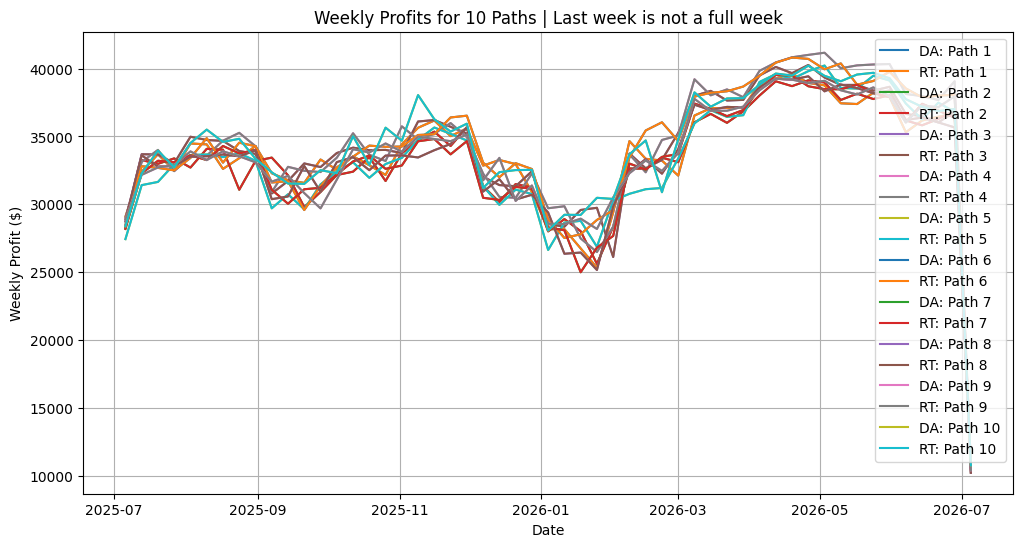

In [30]:
# Select 10 paths to plot
sample_paths_DA = weekly_profits_DA.iloc[:, :10]
sample_paths_RT = weekly_profits_RT.iloc[:, :10]

# Plot the weekly profits for the selected paths
plt.figure(figsize=(12, 6))
for i in range(sample_paths_DA.shape[1]):
    plt.plot(sample_paths_DA.index, sample_paths_DA.iloc[:, i], label=f'DA: Path {i+1}')
    plt.plot(sample_paths_RT.index, sample_paths_DA.iloc[:, i], label=f'RT: Path {i+1}')


plt.title('Weekly Profits for 10 Paths | Last week is not a full week')
plt.xlabel('Date')
plt.ylabel('Weekly Profit ($)')
plt.legend()
plt.grid()
plt.show()

## sample hourly profit paths

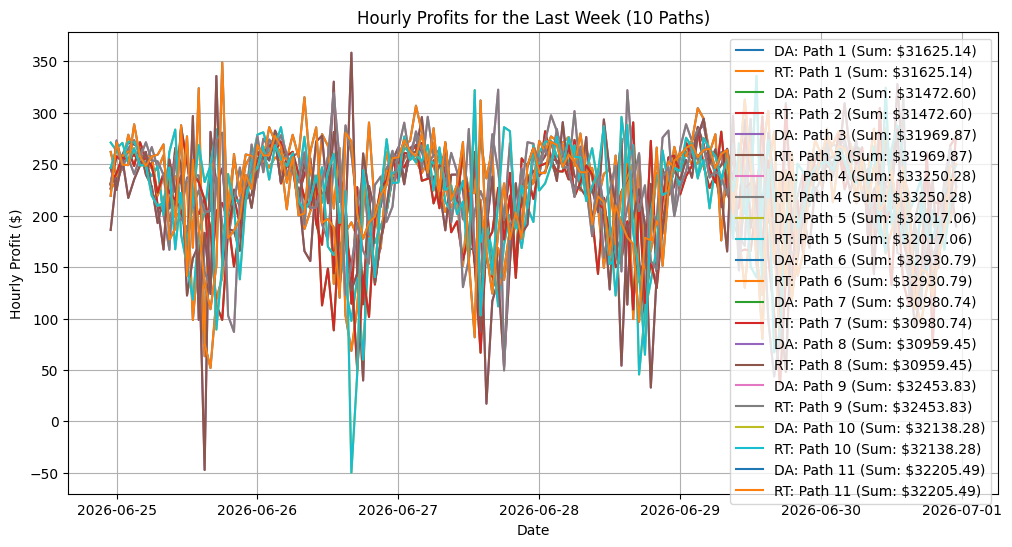

In [31]:
# Select the last week of hourly profits for the first 10 paths
last_week_start = rng[-1] - pd.Timedelta(days=6)
last_week_end = rng[-1]
last_week_data_DA = hourly_profits_DA_df.loc[last_week_start:last_week_end, :10]
last_week_data_RT = hourly_profits_DA_df.loc[last_week_start:last_week_end, :10]

# Calculate the sum of profits for each path for the last week
path_sums_DA = last_week_data_DA.sum()
path_sums_RT = last_week_data_DA.sum()

# Plot the hourly profits for the last week
plt.figure(figsize=(12, 6))
for i in range(last_week_data_DA.shape[1]):
    plt.plot(last_week_data_DA.index, last_week_data_DA.iloc[:, i], label=f'DA: Path {i+1} (Sum: ${path_sums_DA[i]:.2f})')
    plt.plot(last_week_data_RT.index, last_week_data_RT.iloc[:, i], label=f'RT: Path {i+1} (Sum: ${path_sums_RT[i]:.2f})')


plt.title('Hourly Profits for the Last Week (10 Paths)')
plt.xlabel('Date')
plt.ylabel('Hourly Profit ($)')
plt.legend()
plt.grid()
plt.show()

# analysis

## which hours does RT outperform DA?

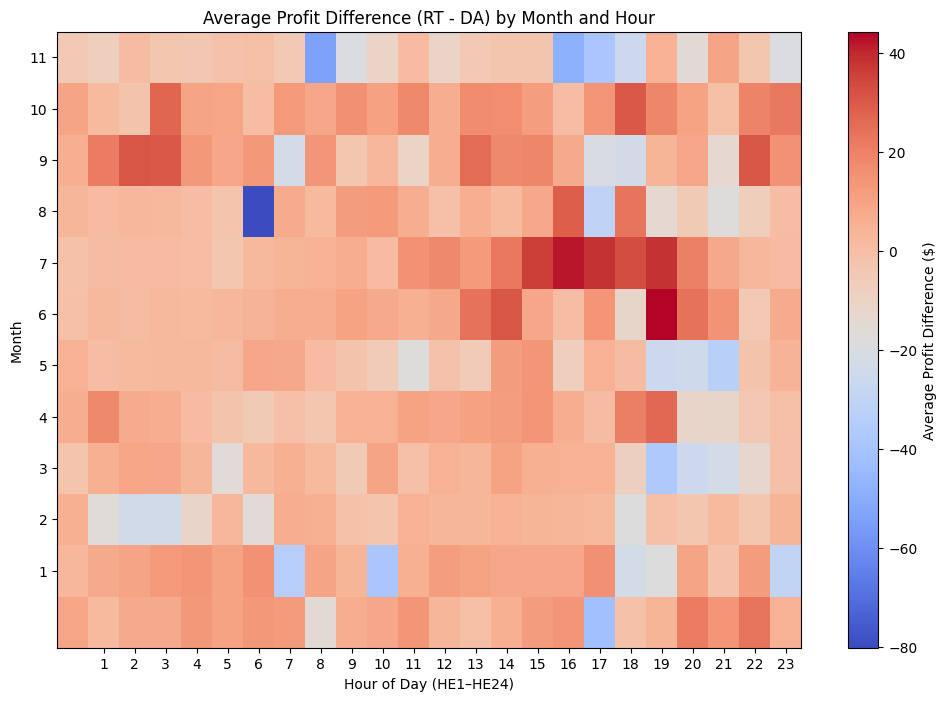

In [37]:
# Calculate the hourly profit difference (RT - DA)
profit_diff = hourly_profits_RT_df - hourly_profits_DA_df

# Add month and hour columns to the profit difference dataframe
profit_diff['MONTH'] = profit_diff.index.month
profit_diff['HOUR'] = profit_diff.index.hour + 1  # Convert to HE1–HE24

# Group by month and hour, then calculate the average profit difference
avg_profit_diff = profit_diff.groupby(['MONTH', 'HOUR']).mean().mean(axis=1).unstack()

# Plot the heatmap of average profit differences
plt.figure(figsize=(12, 8))
plt.title('Average Profit Difference (RT - DA) by Month and Hour')
plt.xlabel('Hour of Day (HE1–HE24)')
plt.ylabel('Month')
plt.xticks(ticks=range(1, 25), labels=range(1, 25))
plt.yticks(ticks=range(1, 13), labels=range(1, 13))
plt.imshow(avg_profit_diff, aspect='auto', cmap='coolwarm', origin='lower')
plt.colorbar(label='Average Profit Difference ($)')
plt.show()

# some more plots, idk if they're that good

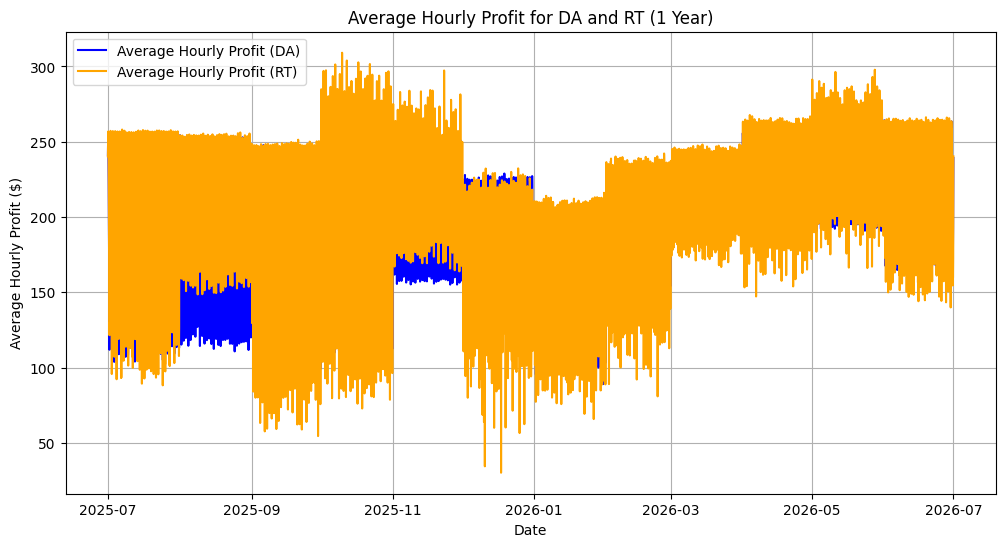

In [33]:
# Calculate the average hourly profit for DA and RT
avg_hourly_profit_DA = hourly_profits_DA_df.mean(axis=1)
avg_hourly_profit_RT = hourly_profits_RT_df.mean(axis=1)

# Plot the average hourly profits
plt.figure(figsize=(12, 6))
plt.plot(avg_hourly_profit_DA.index, avg_hourly_profit_DA, label='Average Hourly Profit (DA)', color='blue')
plt.plot(avg_hourly_profit_RT.index, avg_hourly_profit_RT, label='Average Hourly Profit (RT)', color='orange')

plt.title('Average Hourly Profit for DA and RT (1 Year)')
plt.xlabel('Date')
plt.ylabel('Average Hourly Profit ($)')
plt.legend()
plt.grid()
plt.show()

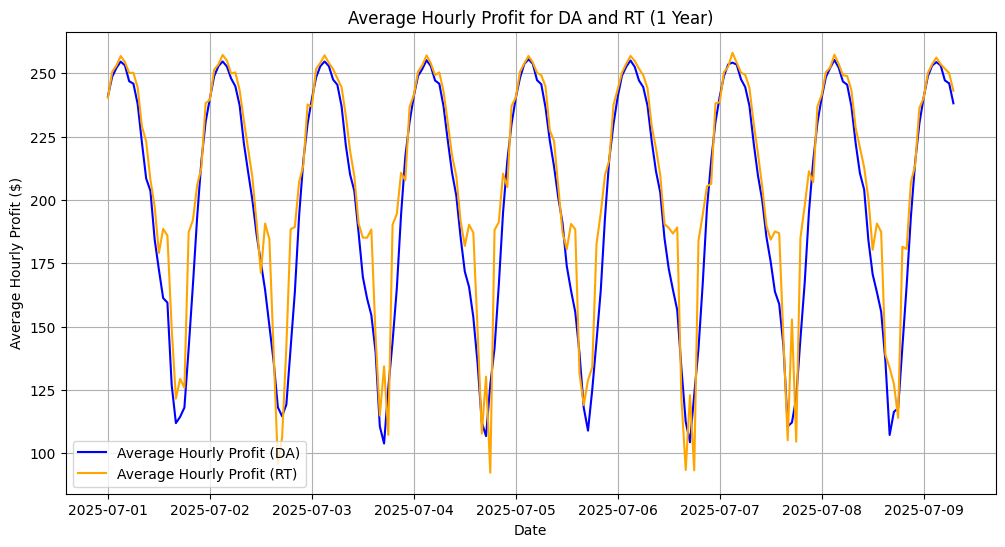

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(avg_hourly_profit_DA.index[:200], avg_hourly_profit_DA[:200], label='Average Hourly Profit (DA)', color='blue')
plt.plot(avg_hourly_profit_RT.index[:200], avg_hourly_profit_RT[:200], label='Average Hourly Profit (RT)', color='orange')

plt.title('Average Hourly Profit for DA and RT (1 Year)')
plt.xlabel('Date')
plt.ylabel('Average Hourly Profit ($)')
plt.legend()
plt.grid()
plt.show()